# COVID Data

Project from https://www.kaggle.com/sixteenpython/covid-19-temperature-air-travel-transmission/notebook

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

import plotly 
import plotly.graph_objs as go #importing graphical objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import data

In [4]:
#full_table = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', parse_dates=['Date'])

full_table = pd.read_csv('covid_19_clean_complete.csv', parse_dates=['Date'])
full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


## Pre-process

In [0]:
# Defining COVID-19 cases as per classifications 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Defining Active Case: Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# Renaming Mainland china as China in the data table
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

# cases in the ships
ship = full_table[full_table['Province/State'].str.contains('Grand Princess')|full_table['Country/Region'].str.contains('Cruise Ship')]

# china and the row
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region']!='China']

# latest
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()


## Statistical Analysis

chose the month which has max confirmed case

In [6]:
#sort data by confirmed cases of month
monTable = full_table.groupby(full_table['Date'].dt.strftime('%B'))['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().sort_values(by='Confirmed', ascending=False).reset_index()
monTable.style.background_gradient(cmap='Reds')

,Date,Confirmed,Deaths,Recovered,Active
0,March,7254206,306521,2361641,4586044
1,February,1673291,46898,380749,1245644
2,January,38534,889,844,36801


get the March data

In [7]:
#filter data
df = full_table
df = df[df['Date'].dt.month.between(3,4)]
print(df.Confirmed.sum())
df.head()

7254206


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
9828,,Afghanistan,33.0000,65.0000,2020-03-01,1,0,0,1
9829,,Albania,41.1533,20.1683,2020-03-01,0,0,0,0
9830,,Algeria,28.0339,1.6596,2020-03-01,1,0,0,1
9831,,Andorra,42.5063,1.5218,2020-03-01,0,0,0,0
9832,,Angola,-11.2027,17.8739,2020-03-01,0,0,0,0


Sort countries by Confirmed

In [8]:
df = df.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
march_accumulate = df.sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
march = march_accumulate.head(11)
march.style.background_gradient(cmap='Reds')

,Country/Region,Confirmed,Deaths,Recovered,Active
0,China,2350949,91871,1855966,403112
1,Italy,999590,92408,115222,791960
2,US,736329,11346,7062,717921
3,Spain,558667,38399,66865,453403
4,Germany,449486,2456,38467,408563
5,Iran,439847,28545,143833,267469
6,France,312319,14768,35433,262118
7,South Korea,225471,2286,43351,179834
8,Switzerland,122574,1774,5421,115379
9,United Kingdom,117563,5918,1575,110070


Visual data

# Temperature Data

March Average temperature\
data resource: [link1](https://www.currentresults.com/Weather/Europe/Cities/temperature-march.php), [link2](https://weatherspark.com/m/105125/3/Average-Weather-in-March-in-Tehran-Iran), [link3](https://www.ncdc.noaa.gov/sotc/national/202003), [link4](https://www.chinahighlights.com/weather/march.htm), [link5](https://www.weather-kr.com/)

In [9]:
temper = pd.read_csv('/content/AverageDailyTemperaturesInMarch.csv')
temper = temper.groupby('Country/Region').mean().reset_index()
temper['AverTemp'] = temper.mean(axis=1)
temper = temper.groupby('Country/Region')['AverTemp'].sum().reset_index()
temper.head()

,Country/Region,AverTemp
0,Austria,5.75
1,Belarus,-1.50
2,Belgium,6.50
3,Canada,1.40
4,China,8.00


merge temper to full_table

In [10]:
mergeTable = pd.merge(march, temper, on=['Country/Region'], how='left')
mergeTable.head(11)

,Country/Region,Confirmed,Deaths,Recovered,Active,AverTemp
0,China,2350949,91871,1855966,403112,8.000000
1,Italy,999590,92408,115222,791960,10.000000
2,US,736329,11346,7062,717921,7.835000
3,Spain,558667,38399,66865,453403,11.000000
4,Germany,449486,2456,38467,408563,4.500000
5,Iran,439847,28545,143833,267469,11.500000
6,France,312319,14768,35433,262118,9.400000
7,South Korea,225471,2286,43351,179834,6.750000
8,Switzerland,122574,1774,5421,115379,5.250000
9,United Kingdom,117563,5918,1575,110070,6.666667


### Statistical Analysis

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

Top 11 countries with confirmed cases

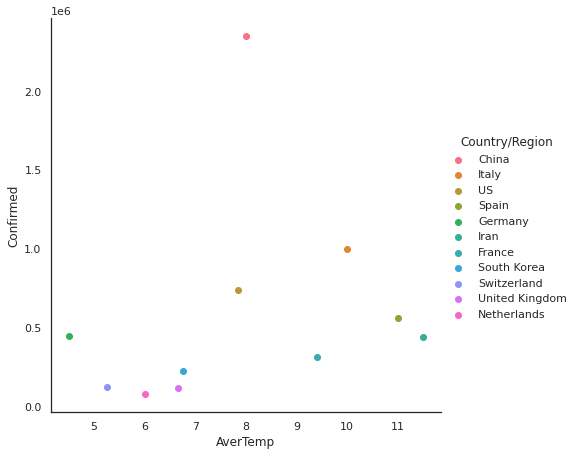

In [12]:
#sns.jointplot(x="AverTemp", y="Active", data=mergeTable, size=5)
sns.FacetGrid(mergeTable, hue="Country/Region", size=6.5).map(plt.scatter, "AverTemp", "Confirmed").add_legend()

Exclude the highest data and Observe again

In [13]:
revChina = mergeTable.drop(mergeTable.index[0])
#revChina[mergeTable['Country/Region'] != 'China']
revChina.head()

,Country/Region,Confirmed,Deaths,Recovered,Active,AverTemp
1,Italy,999590,92408,115222,791960,10.000
2,US,736329,11346,7062,717921,7.835
3,Spain,558667,38399,66865,453403,11.000
4,Germany,449486,2456,38467,408563,4.500
5,Iran,439847,28545,143833,267469,11.500


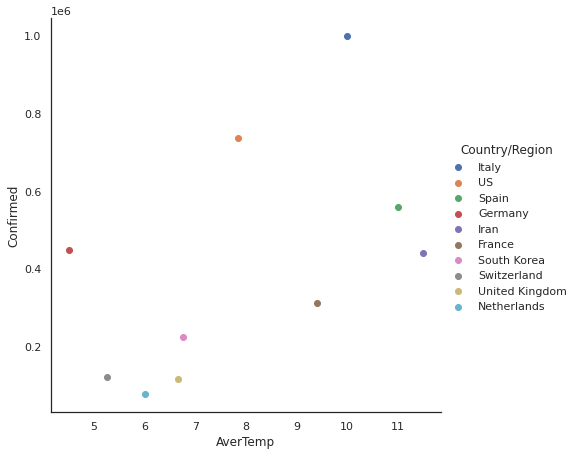

In [14]:
sns.FacetGrid(revChina, hue="Country/Region", size=6.5).map(plt.scatter, "AverTemp", "Confirmed").add_legend()

# Data Visualisation

## Time Series Analysis

In [15]:
TS = full_table
TS = TS.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
TS

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-22,555,17,28,510
1,2020-01-23,654,18,30,606
2,2020-01-24,941,26,36,879
3,2020-01-25,1434,42,39,1353
4,2020-01-26,2118,56,52,2010
...,...,...,...,...,...
63,2020-03-25,467653,21181,113604,332868
64,2020-03-26,529591,23970,121966,383655
65,2020-03-27,593291,27198,130659,435434
66,2020-03-28,660706,30652,138949,491105


In [16]:
import plotly.express as px
df1 = TS.melt(id_vars='Date', value_vars=['Confirmed', 'Recovered'])
fig = px.line(df1, x='Date', y='value', color='variable', title='Time Series of COVID', range_x=['2020-02-20','2020-03-29'])

# Show plot 
fig.show()


## Display of how the planet is with respect to confirmed cases of COVID-19

In [0]:
data = dict(type='choropleth',
            locations = march_accumulate['Country/Region'],
            locationmode = 'country names',
            colorscale = 'Reds',
            # text = march['Brand']
            z = march_accumulate['Confirmed'],
            colorbar = {'title':"number of cases"}
            )

In [0]:
 layout = dict(title = 'Confirmed cases in Global Map',
              geo = dict()
             )

In [19]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

## Display of the average temperatures of those countries

In [0]:
data = dict(type='choropleth',
            locations = march_accumulate['Country/Region'],
            locationmode = 'country names',
            colorscale = 'Reds',
            text = march_accumulate['Confirmed'],
            z = mergeTable['AverTemp'],
            colorbar = {'title':"Average Temperature(。C)"}
            )

In [0]:
 layout = dict(title = 'Confirmed Cases in Global Average Temperature Map',
              geo = dict()
             )

In [22]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

label shows average temperature and confirmed number each country